<a href="https://colab.research.google.com/github/harini9804/fake-image-detection/blob/master/fine_tuning_with_ELA%2C_lower_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cp '/content/drive/My Drive/Colab Notebooks/weibo_data_split_ela.zip' /content

In [0]:
!unzip weibo_data_split_ela.zip -d ./

In [0]:
%mv /content/content/weibo_data_split /content/weibo_data_split_ela

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import os

Using TensorFlow backend.


In [0]:
import numpy as np

In [0]:
# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = '/content/drive/My Drive/Colab Notebooks/bottleneck_fc_model_ela.h5'
# dimensions of our images.
img_width, img_height = 150, 150

In [0]:
base_dir = '/content/weibo_data_split_ela'
train_data_dir = base_dir +'/train_ela'
validation_data_dir = base_dir +'/validation_ela'

nb_train_samples = 2*len(os.listdir(train_data_dir+'/fake_ela/'))
nb_validation_samples = 2*len(os.listdir(validation_data_dir+'/fake_ela/'))
epochs = 50
batch_size = 64

In [0]:
# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

58892288/58889256 [==============================] - 5s 0us/step
Model loaded.


In [0]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [0]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [0]:
new_model = Sequential()
for l in model.layers:
    new_model.add(l)


# CONCATENATE THE TWO MODELS
new_model.add(top_model)


In [0]:
# set the first 14 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:14]:
    layer.trainable = False

In [0]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)      

In [0]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=0.001, momentum = 0.9),
              metrics=['accuracy'])

In [0]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 6794 images belonging to 2 classes.
Found 970 images belonging to 2 classes.


In [0]:
train_generator.class_indices

{'fake_ela': 0, 'real_ela': 1}

In [0]:
new_model.load_weights("/content/drive/My Drive/Colab Notebooks/ela_001.ckpt")

In [0]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/weights_ela_001.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
# new_model.summary()

In [0]:
# FIRST VERSION - 15 LAYERS FREEZE, SGD 0.001
# fine-tune the model
history = new_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks = callbacks_list)

Epoch 1/50
106/106 [==============================] - 103s 969ms/step - loss: 0.6907 - accuracy: 0.5080 - val_loss: 0.6890 - val_accuracy: 0.4979

Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/ela_001.ckpt
Epoch 2/50
106/106 [==============================] - 99s 929ms/step - loss: 0.6927 - accuracy: 0.5007 - val_loss: 0.6922 - val_accuracy: 0.5011

Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/ela_001.ckpt
Epoch 3/50
106/106 [==============================] - 98s 929ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6920 - val_accuracy: 0.4978

Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/ela_001.ckpt
Epoch 4/50
106/106 [==============================] - 98s 926ms/step - loss: 0.6929 - accuracy: 0.5003 - val_loss: 0.6916 - val_accuracy: 0.5011

Epoch 00004: saving model to /content/drive/My Drive/Colab Notebooks/ela_001.ckpt
Epoch 5/50
106/106 [==============================] - 98s 924ms/step - loss: 0.6929 - a

In [0]:
import matplotlib.pyplot as plt


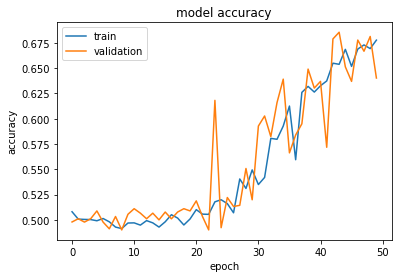

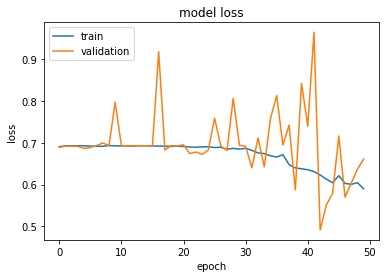

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



---

## Phase 2
Now we unfreeze the 15th layer and add early stopping callback with a patience of 10 epochs - which means, if the validation loss does not get better (lower) than the current best for 10 consecutive epochs, then the training is terminated.

In [0]:
#callback
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only= True,verbose=1)
es_callback = EarlyStopping(patience=10)
callbacks_list = [cp_callback, es_callback]

In [0]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=0.001, momentum = 0.9),
              metrics=['accuracy'])

In [0]:
# fine-tune the model
history = new_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks = callbacks_list)


Epoch 1/50
106/106 [==============================] - 97s 911ms/step - loss: 0.6042 - accuracy: 0.6651 - val_loss: 0.5371 - val_accuracy: 0.6760

Epoch 00001: val_loss improved from inf to 0.53709, saving model to /content/drive/My Drive/Colab Notebooks/weights_ela_001.01-0.54.hdf5
Epoch 2/50
106/106 [==============================] - 97s 919ms/step - loss: 0.6016 - accuracy: 0.6761 - val_loss: 0.6915 - val_accuracy: 0.6876

Epoch 00002: val_loss did not improve from 0.53709
Epoch 3/50
106/106 [==============================] - 96s 910ms/step - loss: 0.5914 - accuracy: 0.6799 - val_loss: 0.7273 - val_accuracy: 0.6214

Epoch 00003: val_loss did not improve from 0.53709
Epoch 4/50
106/106 [==============================] - 95s 899ms/step - loss: 0.5790 - accuracy: 0.6872 - val_loss: 0.6932 - val_accuracy: 0.6214

Epoch 00004: val_loss did not improve from 0.53709
Epoch 5/50
106/106 [==============================] - 96s 908ms/step - loss: 0.5850 - accuracy: 0.6892 - val_loss: 0.6283 - va

In [0]:
import matplotlib.pyplot as plt


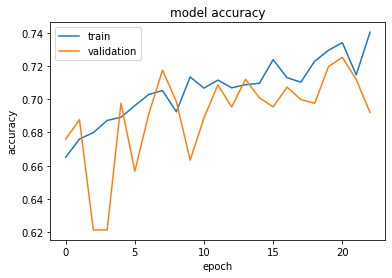

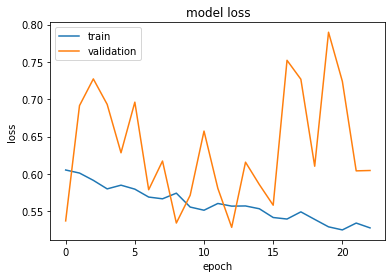

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



---

## Phase 3
The Early Stopping callback is removed and the model is let to run for all 50 epochs.

In [0]:
#callback
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only= True,verbose=1)
# es_callback = EarlyStopping(patience=10)
callbacks_list = [cp_callback]

In [0]:
# fine-tune the model
history = new_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks = callbacks_list)

Epoch 1/50
106/106 [==============================] - 97s 918ms/step - loss: 0.5275 - accuracy: 0.7300 - val_loss: 0.5680 - val_accuracy: 0.7021

Epoch 00001: val_loss improved from inf to 0.56800, saving model to /content/drive/My Drive/Colab Notebooks/weights_ela_001.01-0.57.hdf5
Epoch 2/50
106/106 [==============================] - 97s 916ms/step - loss: 0.5143 - accuracy: 0.7394 - val_loss: 0.7588 - val_accuracy: 0.6921

Epoch 00002: val_loss did not improve from 0.56800
Epoch 3/50
106/106 [==============================] - 96s 906ms/step - loss: 0.5057 - accuracy: 0.7423 - val_loss: 0.8434 - val_accuracy: 0.7031

Epoch 00003: val_loss did not improve from 0.56800
Epoch 4/50
106/106 [==============================] - 96s 904ms/step - loss: 0.5062 - accuracy: 0.7482 - val_loss: 0.6846 - val_accuracy: 0.7163

Epoch 00004: val_loss did not improve from 0.56800
Epoch 5/50
106/106 [==============================] - 96s 907ms/step - loss: 0.5155 - accuracy: 0.7421 - val_loss: 0.6279 - va

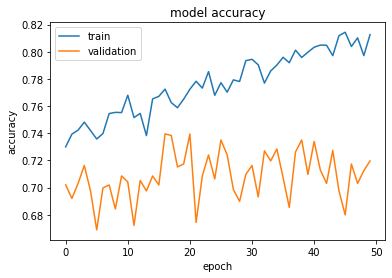

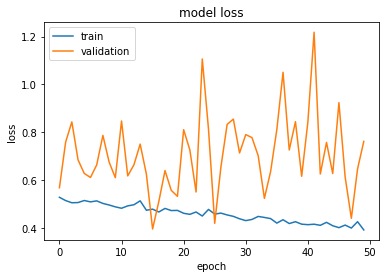

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
model_2 = new_model

In [0]:
model_2.load_weights('/content/drive/My Drive/Colab Notebooks/weights_ela_001.16-0.40.hdf5')

In [0]:
t_datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
val_gen = t_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', shuffle = False)

Found 970 images belonging to 2 classes.


In [0]:
predictions = model_2.predict_generator(val_gen, nb_validation_samples // batch_size+1)
len(predictions)

970

In [0]:
y_pred = ["Real" if x >= 0.5 else "Fake" for x in predictions ]

In [0]:
target_labels = ["Fake", "Real"]

In [0]:
actual_labels = ["Fake" if x == 0 else "Real" for x in validation_generator.classes]

In [0]:
print('Confusion Matrix')
cm = confusion_matrix(actual_labels, y_pred,labels=["Fake", "Real"])
print(confusion_matrix(actual_labels, y_pred))

Confusion Matrix
[[385 100]
 [186 299]]


In [0]:
print(classification_report(actual_labels, y_pred, 
target_names=['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.67      0.79      0.73       485
        Real       0.75      0.62      0.68       485

    accuracy                           0.71       970
   macro avg       0.71      0.71      0.70       970
weighted avg       0.71      0.71      0.70       970



In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

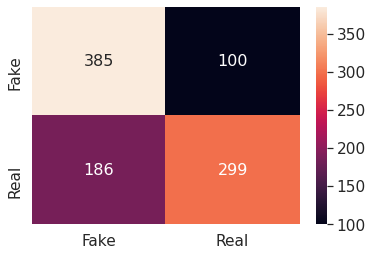

In [0]:
df_cm = pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt="d",xticklabels=target_labels,yticklabels=target_labels) # font size

plt.show()